In [8]:
import os
import pandas as pd
import joblib
from sklearn.pipeline import make_pipeline
import numpy as np
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from category_encoders import MEstimateEncoder
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from category_encoders import OneHotEncoder

In [11]:
class Dataset:
    def __init__(self):
        '''
        d1~d1913為訓練資料，共1913天，原始特徵提供。
        d1914~1941為驗證，共28天，應該是比賽結束後釋出。
        d1942~d1966為測試，共28天，隱藏起來的資料範圍。
        故訓練時應該用~D1885預測D1886~D1913
          驗證時應該用~D1913預測D1914~D1941
          測試時應該用~D1941預測D1942~D1966
          這樣驗證水準才會最近似於預測水準
        
        但若這樣會犧牲掉很多的資料，故若針對預測不同天的未來準備不同的資料會能使用到更近期的資料去訓練
        ex 預測下一天的資料可用~d1912預測~d1913
           預測下兩天的資料可用~d1911預測~d1913依此類推
        '''
        val_csv='..\input\sales_train_validation.csv'
        eval_csv='..\input\sales_train_evaluation.csv'
        sample_sub_csv='..\input\sample_submission.csv'



        val_df_id, val_df_d_sales = self.preprocess(val_csv) # 讀取資料
        eval_df_id, eval_df_d_sales = self.preprocess(eval_csv) # 讀取資料

        sample_sub_df=pd.read_csv(sample_sub_csv,index_col=0)

        # all_df_id = pd.concat([val_df_id,eval_df_id], axis=0)
        # all_df_d_sales = pd.concat([val_df_d_sales,eval_df_d_sales], axis=0)
        # sample_sub_df_id =all_df_id.loc(sample_sub_df.index)
        # sample_sub_df_sales = all_df_id.loc(sample_sub_df.index)

        # self.df_train = val_df_d_sales.iloc[:,:-28]
        # self.df_val =  eval_df_d_sales.iloc[:,:-28]
        def data_rate_transfer(df_sales:pd.DataFrame):
            for col in df_sales.columns.to_list()[:-1]:
                df_sales[col]=df_sales[col]/(df_sales[col]+1)
            return df_sales

        self.X_train = val_df_d_sales.iloc[:,:-28]
        self.X_train = data_rate_transfer(self.X_train)
        self.X_train.columns=[f'D_{i}' for i in range(self.X_train.shape[1])]
        self.y_train = val_df_d_sales.iloc[:,-28:]
        self.X_val = eval_df_d_sales.iloc[:,28:-28]
        self.X_val = data_rate_transfer(self.X_val)
        self.X_val.columns=[f'D_{i}' for i in range(self.X_val.shape[1])]
        self.y_val = eval_df_d_sales.iloc[:,-28:]

        X_all = pd.concat([self.X_train, self.X_val],axis=0)
        self.X_test =X_all.loc[sample_sub_df.index.to_list()]
        self.X_test = data_rate_transfer(self.X_test)
        self.X_train = self.concat(self.X_train, val_df_id)
        self.X_val = self.concat(self.X_val, eval_df_id)

        all_id=pd.concat([val_df_id,eval_df_id],axis=0)
        self.X_test = self.concat(self.X_test, all_id.loc[sample_sub_df.index.to_list()])


        # self.X_train, self.X_local_val, self.y_train, self.y_local_val = train_test_split(self.x, self.y, test_size=0.2, random_state=42)

            # self.sales = pd.read_csv(submission_csv,index_col=0)
        # self._sales_processed = (
        #     sales
        #     .drop(["警示編號", "監控層級", "觸發說明"], axis=1)
        #     .assign(**sales.資料日期.dt.isocalendar(),
        #             month=sales.資料日期.dt.month,
        #             quarter=sales.資料日期.dt.quarter,
        #             hfy=sales.資料日期.dt.quarter.isin([3, 4])+1,
        #             bigMon=sales.資料日期.dt.month.isin([1, 3, 5, 7, 8, 10, 12]).astype(int))  # 將sales整理出更多的特徵資料
        # )
        # self.txn_c = txn[txn['tran_type'] == 'DEBIT'].drop("tran_type", axis=1)
        # self.txn_d = txn[txn['tran_type'] ==
        #                  'CREDIT'].drop("tran_type", axis=1)
        # self.txn_t = txn[txn['tran_type'] == 'TXN'].drop("tran_type", axis=1)

        # self._txn_processed = txn  # _get_data_from_sql整理出的txn資料
        # self._risk_processed = risk  # _get_data_from_sql整理出的risk資料
        # self._info_processed = info  # _get_data_from_sql整理出的info資料
        # self.ac = ac  # _get_data_from_sql從VW_NP_FSC_PARTY_ACCOUNT_BRIDGE整理出的客帳戶對照

        # self.train = self._get_data("train")  # VIP訓練資料
        # self.val = self._get_data("val")  # VIP驗證資料
        # self.test = self._get_data("test")  # VIP當天資料

        # self.seg_mapping = self._get_cust_seg_def()

    def preprocess(self,file_name):
        data = pd.read_csv(file_name,index_col=0) # 讀取資料
        df_id = data.iloc[:,:5]
        df_d_sales = data.iloc[:,5:]
        df_id = self._preprocess_obj_feature(df_id)
        return df_id, df_d_sales
    
    def concat(self, X_df, obj_df):

        return pd.concat([obj_df,X_df], axis=1)

    def _preprocess_obj_feature(self, obj_df):
        #onehot encoding feature
        self.encoder1 = OneHotEncoder()
        self.encoder1.fit(obj_df)
        obj_df = self.encoder1.transform(obj_df)

        return obj_df
    
    def preprocess_target(self, data, index):
        return data.loc[index].iloc[:,-28:]

In [12]:
# sample_sub_df=pd.read_csv('..\input\sample_submission.csv',index_col=0)
# sample_sub_df.index

In [20]:
sample_sub_df.shape

(60980, 28)

In [13]:
dataset=Dataset()


C:\Users\Dylan.Tang\AppData\Local\Temp\ipykernel_3056\3780305370.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sales[col]=df_sales[col]/(df_sales[col]+1)
C:\Users\Dylan.Tang\AppData\Local\Temp\ipykernel_3056\3780305370.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sales[col]=df_sales[col]/(df_sales[col]+1)


In [4]:
dataset.X_train.columns[dataset.X_train.isna().any()].tolist()

[]

In [3]:
test=pd.read_csv('..\input\sales_train_evaluation.csv',index_col=0)

In [27]:
test.loc['HOBBIES_1_001_CA_1_evaluation']

item_id     HOBBIES_1_001
dept_id         HOBBIES_1
cat_id            HOBBIES
store_id             CA_1
state_id               CA
                ...      
d_1937                  0
d_1938                  3
d_1939                  3
d_1940                  0
d_1941                  1
Name: HOBBIES_1_001_CA_1_evaluation, Length: 1946, dtype: object

In [4]:
test.head()

,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
id,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [67]:
train_data.X_train

,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
id,,,,,,,,,,,,,,,,,,,,,
FOODS_3_164_CA_4_evaluation,0.983928,2.205954,1.806054,0.907511,1.436865,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
HOBBIES_1_198_TX_1_evaluation,1.037716,0.814663,0.669381,1.008855,1.165628,0,0,0,0,0,...,0,1,1,0,0,0,0,0,1,0
FOODS_1_084_CA_3_evaluation,1.118399,1.315278,1.806054,2.085602,1.436865,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
FOODS_2_180_CA_4_evaluation,1.252869,1.245477,1.806054,0.907511,1.436865,0,0,0,0,0,...,2,0,1,2,2,0,0,1,0,1
HOUSEHOLD_2_121_TX_1_evaluation,0.930140,0.347767,0.865138,1.008855,1.165628,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FOODS_3_137_WI_3_evaluation,1.091504,2.205954,1.806054,1.070187,1.159615,0,0,0,0,0,...,0,0,0,1,0,0,0,0,2,0
FOODS_3_117_CA_2_evaluation,1.629387,2.205954,1.806054,1.287635,1.436865,15,5,5,5,9,...,2,1,1,0,1,1,1,0,4,2
HOUSEHOLD_1_302_CA_1_evaluation,1.010822,1.365977,0.865138,1.466710,1.436865,0,3,0,1,0,...,3,1,1,0,0,0,0,0,2,0


In [14]:
class Models:
    def __init__(self, is_load=False):
        '''


        '''
        
        package_dir = os.path.dirname(os.path.abspath(os.getcwd()))
        self.model_path = os.path.join(package_dir,'models')
        os.makedirs(self.model_path, exist_ok=True)
        
        if is_load:
            self._load_models()
        else:
            self._set_28_models()

    # def _create_pipe(self, X_train):
    #     return make_pipeline(
    #         TargetEncoder(cols=X_train.columns[X_train.dtypes == 'object'],
    #                       handle_missing='return_nan'),
    #         SimpleImputer(missing_values=np.nan, strategy='mean'),
    #         XGBRegressor()
    #     )
    def _load_models(self):
        
        self.models = [joblib.load(os.path.join(self.model_path, fn))
                        for fn in sorted(os.listdir(self.model_path))]

    def _set_28_models(self):
        self.models=[]
        for i in range(28):
            self.models.append(XGBRegressor())

    def _train_28_models(self, X_train, X_local_val, y_train, y_local_val):
        for i in range(28):
            
            # from IPython import embed
            # embed()
            self.models[i].fit(X_train, y_train.iloc[:,i])
            self.models[i]
            y_pred = self.models[i].predict(X_local_val)
            # 計算均方根誤差
            mse = mean_squared_error(y_local_val.iloc[:,i], y_pred)
            rmse = np.sqrt(mse)
            print("mse:",mse,"     Root Mean Squared Error:", rmse)
            joblib.dump(self.models[i], os.path.join(
                self.model_path, f"model_day{str(i).zfill(2)}.pkl"), compress=3)
    def models_predict(self, X_val:pd.DataFrame, name='result_simple_rate.csv'):

        output = X_val.iloc[:,0:1]
        for i in range(28):
            val_data_tmp_y = self.models[i].predict(X_val)
            output[f'F{i+1}'] = val_data_tmp_y

        output=output.iloc[:,1:]
        output.to_csv(name)


In [15]:
models=Models()

In [16]:
models._train_28_models(dataset.X_train,dataset.X_val,dataset.y_train,dataset.y_val)

mse: 4.084012986434139      Root Mean Squared Error: 2.0208941056953327
mse: 3.4763103135669295      Root Mean Squared Error: 1.8644866085780636
mse: 3.490512024484964      Root Mean Squared Error: 1.868291204412461
mse: 3.526947140814891      Root Mean Squared Error: 1.8780168105783535
mse: 4.5571368825692655      Root Mean Squared Error: 2.13474515635222
mse: 5.80532279663803      Root Mean Squared Error: 2.409423747836405
mse: 6.1935269695395005      Root Mean Squared Error: 2.4886797643609153
mse: 5.0995576096596595      Root Mean Squared Error: 2.2582200091354383
mse: 5.529418109745854      Root Mean Squared Error: 2.3514714775531202
mse: 5.1709516816504815      Root Mean Squared Error: 2.273972665106263
mse: 4.7503148975928315      Root Mean Squared Error: 2.1795217130354154
mse: 6.357903531575793      Root Mean Squared Error: 2.521488356422808
mse: 7.153310328641737      Root Mean Squared Error: 2.6745673161544725
mse: 7.18392253237848      Root Mean Squared Error: 2.68028403949

In [17]:
output = dataset.X_test.iloc[:,0:1]
for i in range(28):
    val_data_tmp_y = models.models[i].predict(dataset.X_test)
    output[f'F{i+1}'] = val_data_tmp_y

output=output.iloc[:,1:]

In [24]:
output.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
id,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001_CA_1_validation,0.518300,0.390438,0.494012,0.419980,0.437282,0.583178,0.423748,0.470456,0.264672,0.334790,...,0.234926,0.476948,0.380897,0.385664,0.359085,0.298503,0.298179,0.418097,0.380701,0.554816
HOBBIES_1_002_CA_1_validation,0.436227,0.248340,0.288647,0.241924,0.232835,0.383083,0.142417,0.209568,0.157119,0.307868,...,0.207227,0.260577,0.287069,0.251503,0.218535,0.153306,0.184349,0.156007,0.270541,0.315521
HOBBIES_1_003_CA_1_validation,0.231394,0.201472,0.121414,0.149915,0.243012,0.369780,0.187196,0.154851,0.260282,0.142073,...,0.113895,0.234185,0.252252,0.219255,0.237672,0.150256,0.094343,0.203733,0.281207,0.296095
HOBBIES_1_004_CA_1_validation,0.781375,0.716747,0.544603,0.643491,0.820327,0.828736,0.561975,0.709652,0.549703,0.820257,...,0.552595,0.431046,0.936273,0.514765,0.305333,0.497454,0.530943,0.437648,1.137426,1.047302
HOBBIES_1_005_CA_1_validation,0.378706,0.304177,0.295718,0.395916,0.544474,0.312679,0.468076,0.361975,0.343256,0.211991,...,0.240503,0.352268,0.239041,0.246361,0.259205,0.333380,0.226937,0.300829,0.415865,0.517916


In [18]:
output.to_csv('result_simple_rate.csv')

In [10]:
import matplotlib.pyplot as plt

In [4]:
models=Models(is_load=True)


In [8]:
model_0_importance = models.models[0].get_booster().get_score()

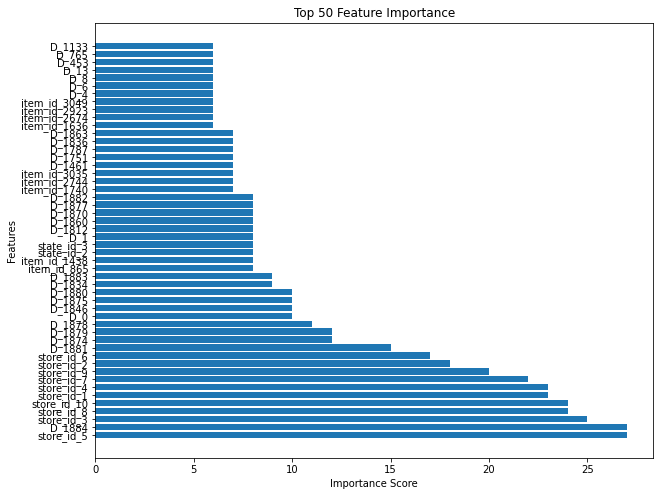

In [13]:
features = list(model_0_importance.keys())
importance = list(model_0_importance.values())

# 按照重要性得分進行排序
sorted_indices = sorted(range(len(importance)), key=lambda k: importance[k], reverse=True)
top_features = [features[i] for i in sorted_indices[:50]]
top_importance = [importance[i] for i in sorted_indices[:50]]


plt.figure(figsize=(10, 8))
# 繪製長條圖


plt.barh(range(len(top_features)), top_importance, align='center')
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Top 50 Feature Importance')
plt.show()

In [14]:
top_features[:50]

['store_id_5',
 'D_1884',
 'store_id_3',
 'store_id_8',
 'store_id_10',
 'store_id_1',
 'store_id_4',
 'store_id_7',
 'store_id_9',
 'store_id_2',
 'store_id_6',
 'D_1881',
 'D_1874',
 'D_1879',
 'D_1878',
 'D_0',
 'D_1846',
 'D_1875',
 'D_1880',
 'D_1834',
 'D_1883',
 'item_id_865',
 'item_id_1438',
 'state_id_2',
 'state_id_3',
 'D_1',
 'D_1812',
 'D_1860',
 'D_1870',
 'D_1877',
 'D_1882',
 'item_id_1740',
 'item_id_2744',
 'item_id_3035',
 'D_1461',
 'D_1751',
 'D_1787',
 'D_1836',
 'D_1863',
 'item_id_1636',
 'item_id_2674',
 'item_id_2923',
 'item_id_3049',
 'D_4',
 'D_6',
 'D_8',
 'D_13',
 'D_453',
 'D_765',
 'D_1133']

In [22]:
list(model_0_importance.keys())[-10:]

['D_1875',
 'D_1876',
 'D_1877',
 'D_1878',
 'D_1879',
 'D_1880',
 'D_1881',
 'D_1882',
 'D_1883',
 'D_1884']

In [23]:
import pandas as pd

# 创建示例 DataFrame
data = {'A': [1, 2, 3], 'B': [4, 5, 6], 'C': [7, 8, 9]}
df = pd.DataFrame(data, index=['row1', 'row2', 'row3'])

In [27]:
df.columns.to_list()

['A', 'B', 'C']

In [28]:
df[df.columns]

,A,B,C
row1,1,4,7
row2,2,5,8
row3,3,6,9


In [29]:
df['a']=0

In [30]:
df

,A,B,C,a
row1,1,4,7,0
row2,2,5,8,0
row3,3,6,9,0


In [2]:
import pandas as pd

# Create a sample DataFrame
data = {'A': [1, 2, 3], 'B': [4, 5, 6], 'C': [7, 8, 9]}
df = pd.DataFrame(data, index=['row1', 'row2', 'row3'])

# Reindex the DataFrame
new_index = ['row3', 'row1', 'row4']
new_columns = ['B', 'A', 'D']
new_df = df.reindex(index=new_index, columns=new_columns)

print(new_df)

        B    A   D
row3  6.0  3.0 NaN
row1  4.0  1.0 NaN
row4  NaN  NaN NaN


In [9]:
df[['B', 'A']]

,B,A
row1,4,1
row2,5,2
row3,6,3


In [33]:
new_df.columns=[f'Previous_Day_{i}' for i in range(new_df.shape[1],0,-1)]

In [39]:
new_df

,Previous_Day_3,Previous_Day_2,Previous_Day_1
row3,6.0,3.0,NaN
row1,4.0,1.0,NaN
row4,NaN,NaN,NaN


In [34]:
new_df.columns

Index(['Previous_Day_3', 'Previous_Day_2', 'Previous_Day_1'], dtype='object')

In [40]:
new_df[['Previous_Day_3', 'Previous_Day_2']]

,Previous_Day_3,Previous_Day_2
row3,6.0,3.0
row1,4.0,1.0
row4,NaN,NaN


In [3]:
df

,A,B,C
row1,1,4,7
row2,2,5,8
row3,3,6,9


In [6]:
df.iloc[:,1:-0]

""
row1
row2
row3
